# Import required packages

In [1]:
from numpy import load
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from pycm import ConfusionMatrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import pickle

# Set path to base models val/test predictions (numpy arrays) and load them

In [2]:
model_path = 'C:\\Users\\SWONG\\PRS_project\\Model\\'
arr_path = 'C:\\Users\\SWONG\\PRS_project\\Model\\numpy_baseClassifier_predictions\\'

# load numpy array from npy file
np_val_asym_preds = load(arr_path+'val_preds_asym.npy')
np_val_border_preds = load(arr_path+'val_preds_border.npy')
np_val_center_preds = load(arr_path+'val_preds_center.npy')
np_val_orig_preds = load(arr_path+'val_preds_orig.npy')
np_val_blueWhite_preds = load(arr_path+'val_preds_blueWhite.npy')

np_test_asym_preds = load(arr_path+'test_preds_asym.npy')
np_test_border_preds = load(arr_path+'test_preds_border.npy')
np_test_center_preds = load(arr_path+'test_preds_center.npy')
np_test_orig_preds = load(arr_path+'test_preds_orig.npy')
np_test_blueWhite_preds = load(arr_path+'test_preds_blueWhite.npy')

In [3]:
#storing the true labels in lists
train_labelled_class = [0]*902 + [1]*7209
val_labelled_class = [0]*100 + [1]*802
test_labelled_class = [0]*111 + [1]*891

# Define the X (input) and the Y (true labels) for val and test data

In [4]:
X_val = np.concatenate(np.array([np_val_asym_preds, np_val_border_preds, np_val_center_preds, np_val_orig_preds, np_val_blueWhite_preds]), axis=1)
Y_val = np.array(val_labelled_class)
X_test = np.concatenate(np.array([np_test_asym_preds, np_test_border_preds, np_test_center_preds, np_test_orig_preds, np_test_blueWhite_preds]), axis=1)
Y_test = np.array(test_labelled_class)

In [5]:
param_grid = {'C':[0.01,0.1,1,10,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'gamma':['scale','auto']}
grid = GridSearchCV(SVC(), param_grid)
grid.fit(X_val,Y_val)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [6]:
print(grid.best_params_)
print(grid.score(X_test, Y_test))

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.9301397205588823


# Train SVM classifier using base models val predictions

In [14]:
svm_clf = SVC(C=100, kernel='rbf', gamma='auto', probability=True, class_weight='balanced')
svm_clf.fit(X_val, Y_val)
svm_pred_class = svm_clf.predict(X_test)
svm_pred_proba = svm_clf.predict_proba(X_test)

# SVM Accuracy, Classification Report, Confusion Matrix

In [15]:
#SVM classifier, trained on base model valiadation data predictions
        
print("Accuracy:",accuracy_score(Y_test,svm_pred_class)*100)
print("Report:", classification_report(Y_test,svm_pred_class))

Accuracy: 87.92415169660678
Report:               precision    recall  f1-score   support

           0       0.47      0.86      0.61       111
           1       0.98      0.88      0.93       891

    accuracy                           0.88      1002
   macro avg       0.73      0.87      0.77      1002
weighted avg       0.92      0.88      0.89      1002



In [16]:
print(ConfusionMatrix(actual_vector=list(Y_test),predict_vector=(svm_pred_class)))

Predict   0         1         
Actual
0         95        16        

1         105       786       





Overall Statistics : 

95% CI                                                            (0.85907,0.89942)
ACC Macro                                                         0.87924
ARI                                                               0.45622
AUNP                                                              0.86901
AUNU                                                              0.86901
Bangdiwala B                                                      0.85076
Bennett S                                                         0.75848
CBA                                                               0.67858
CSI                                                               0.59653
Chi-Squared                                                       336.50336
Chi-Squared DF                                                    1
Conditional Entropy                                

In [26]:
#SVM classifier, trained on base model valiadation data predictions

#class predictions for each image based on probabilities
Y_pred = []
threshold = 0.5

for pred in svm_pred_proba[:,1]:
    if (pred <= threshold):
        Y_pred.append(0)
    elif (pred > threshold):
        Y_pred.append(1)

print("Accuracy:",accuracy_score(Y_test, Y_pred)*100)
print("Report:", classification_report(Y_test, Y_pred))

Accuracy: 91.81636726546905
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Report:               precision    recall  f1-score   support

           0       0.65      0.57      0.61       111
           1       0.95      0.96      0.95       891

    accuracy                           0.92      1002
   macro avg       0.80      0.76      0.78      1002
weighted avg       0.91      0.92      0.92      1002



# AUC Score

In [18]:
#getting AUC score
roc_auc_svm = roc_auc_score(Y_test, svm_pred_class)
roc_auc_svm_proba = roc_auc_score(Y_test, svm_pred_proba[:,1])

print("AUC Score (SVM): ", roc_auc_svm)
print("AUC Score (SVM (proba)): ", roc_auc_svm_proba)

AUC Score (SVM):  0.8690053690053691
AUC Score (SVM (proba)):  0.9308702642035975


# Plot ROC curve and save

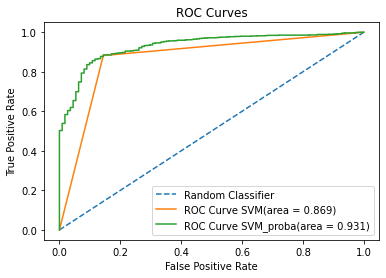

Path to plot: C:\Users\SWONG\PRS_project\Model\SVM_Arbitrator_roc.png


In [19]:
#plotting ROC
fpr1, tpr1, thresholds1 = roc_curve(Y_test, svm_pred_class)
fpr2, tpr2, thresholds2 = roc_curve(Y_test, svm_pred_proba[:,1])

plt.figure()
plt.plot([0,1],[0,1],'--', label='Random Classifier')
plt.plot(fpr1,tpr1,label='ROC Curve SVM(area = %0.3f)' %roc_auc_svm)
plt.plot(fpr2,tpr2,label='ROC Curve SVM_proba(area = %0.3f)' %roc_auc_svm_proba)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves")
plt.legend(loc="lower right")

roc_plotpath  = model_path + 'SVM_Arbitrator' + '_roc.png'
plt.savefig(roc_plotpath)
plt.show()
print("Path to plot:", roc_plotpath)

# Save model to disk

In [20]:
# save the model to disk
filename = 'SVM_Arbitrator.sav'
pickle.dump(svm_clf, open(filename, 'wb'))